In [1]:
# --- 1. Import Necessary Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

# Set plotting style
sns.set(style="whitegrid")

In [2]:
# --- 2. Load Processed Data (v1.0) ---
data_path = '../data/raw_data_1.0.csv'

print(f"--- Loading v1.0 data ---")
print(f"File path: '{data_path}'")

data_path_v2 = '../data/raw_data_2.0.csv'

print(f"--- Loading v2.0 (PCTL_BNT cleaned) data ---")
df_v2 = pd.read_csv(data_path_v2)

try:
    df = pd.read_csv(data_path)
    print("\nData loaded successfully!")
except FileNotFoundError:
    print(f"\nError: Data file not found at '{data_path}'")
    print("Please confirm you have successfully run the processing/process_main_dataset.py and processing/clean_pctl_bnt.py scripts.")

--- Loading v1.0 data ---
File path: '../data/raw_data_1.0.csv'
--- Loading v2.0 (PCTL_BNT cleaned) data ---

Data loaded successfully!


In [3]:
# --- 2.1. Optimize Data Types ---
print("Checking for columns that can be converted from float to integer...")

cols_converted = []
for col in df.columns:
    # Only check float type columns
    if pd.api.types.is_float_dtype(df[col]):
        # Check if all non-null values can be considered integers
        if (df[col].dropna() % 1 == 0).all():
            # Use nullable integer type 'Int64' to handle potential NaN values
            df[col] = df[col].astype('Int64')
            cols_converted.append(col)

if cols_converted:
    print(f"\nSuccessfully converted {len(cols_converted)} columns to 'int64':")
    # For brevity, we only print the first few
    print(sorted(cols_converted)[:10], "...")
else:
    print("\nNo columns needed conversion.")

print("\n--- Optimized Data Types ---")
df.info()


Checking for columns that can be converted from float to integer...

Successfully converted 42 columns to 'int64':
['DVS_BNT', 'DVS_FAS', 'DVS_JLO_MSSA', 'DVS_LNS', 'DVS_SFTANIM', 'DVT_DELAYED_RECALL', 'DVT_FAS', 'DVT_RECOG_DISC_INDEX', 'DVT_RETENTION', 'DVT_SFTANIM'] ...

--- Optimized Data Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15316 entries, 0 to 15315
Data columns (total 59 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PATNO                 15316 non-null  int64  
 1   EVENT_ID              15316 non-null  object 
 2   DVS_JLO_MSSA          14568 non-null  Int64  
 3   DVZ_TMTA              8052 non-null   float64
 4   DVT_SFTANIM           14601 non-null  Int64  
 5   TMT_B                 8075 non-null   Int64  
 6   DVT_SDM               14549 non-null  float64
 7   cogstate              13833 non-null  Int64  
 8   tau                   4594 non-null   float64
 9   SDMTOTAL              

In [4]:
# --- 3. Basic Data Overview ---
print("--- Basic Data Information ---")
print(f"Data Shape (Rows, Columns): {df.shape}\n")

print("--- First 20 Rows of Data ---")
display(df.head(20))



--- Basic Data Information ---
Data Shape (Rows, Columns): (15316, 59)

--- First 20 Rows of Data ---


,PATNO,EVENT_ID,DVS_JLO_MSSA,DVZ_TMTA,DVT_SFTANIM,TMT_B,DVT_SDM,cogstate,tau,SDMTOTAL,...,TMT_A,DVZ_TMTB,clockdraw,age_datscan,stai_trait,MSEADLG,DVT_FAS,hvlt_retention,age,COHORT
0,100001,BL,13,-1.37,49,87,55.83,1,NaN,50,...,43,-2.14,5,67.306849,21,90,41,1.000000,67.386301,1
1,100001,V04,13,-0.92,53,59,55.83,1,NaN,50,...,40,0.87,7,68.536986,26,95,48,0.714286,67.386301,1
2,100001,V06,12,-1.37,57,73,50.00,1,NaN,44,...,43,-0.63,7,69.531507,28,95,41,0.750000,67.386301,1
3,100001,V08,9,0.22,43,97,55.00,1,NaN,49,...,37,-0.45,5,NaN,29,95,48,0.500000,67.386301,1
4,100001,V10,14,0.01,51,106,36.00,1,NaN,28,...,40,-0.82,4,71.312329,22,90,52,0.428571,67.386301,1
5,100002,BL,16,0.37,45,60,37.50,1,NaN,37,...,28,0.42,6,58.405479,28,95,34,0.375000,58.517808,1
6,100002,V04,14,-0.13,45,70,31.25,1,NaN,32,...,33,-0.06,7,59.649315,32,95,37,1.111111,58.517808,1
7,100002,V06,13,-0.82,35,58,43.75,1,NaN,42,...,37,0.35,7,NaN,21,95,41,0.833333,58.517808,1
8,100002,V08,13,-1.53,53,97,36.25,1,NaN,36,...,42,-1.74,7,NaN,24,90,49,0.714286,58.517808,1
9,100002,V10,14,0.05,49,70,25.00,1,NaN,27,...,31,-0.29,7,NaN,23,100,38,0.600000,58.517808,1


In [5]:
# --- 3.1. Feature Type Analysis ---
import json

print("--- Feature Type Analysis ---")

# Load expected value ranges
expected_ranges_path = '../data/expected_value_range.json'
try:
    with open(expected_ranges_path, 'r') as f:
        expected_ranges = json.load(f)
except FileNotFoundError:
    print(f"Warning: Expected value range file not found at '{expected_ranges_path}'")
    expected_ranges = {}

# Store analysis results
feature_analysis = []

# Iterate over all columns
for col in df.columns:
    # Get basic information
    dtype = df[col].dtype
    unique_count = df[col].nunique()
    
    # Initialize extra information
    value_range = 'N/A' # Default for non-numeric columns
    mean_val = 'N/A'
    std_dev = 'N/A'

    # Infer feature type and calculate range
    if col == 'COHORT':
        feature_type = 'Target'
    elif col == 'PATNO':
        feature_type = 'Identifier'
    elif dtype == 'object':
        feature_type = 'Categorical-String'
    elif pd.api.types.is_numeric_dtype(dtype):
        # If the column has no valid values, min/max will raise an error, so handle it
        if not df[col].dropna().empty:
            min_val = df[col].min()
            max_val = df[col].max()
            value_range = f"{min_val:.2f} - {max_val:.2f}"
            # Calculate mean and standard deviation
            mean_val = f"{df[col].mean():.2f}"
            std_dev = f"{df[col].std():.2f}"
        else:
            value_range = 'All NaN'
            mean_val = 'All NaN'
            std_dev = 'All NaN'

        # Further distinguish numeric types
        if unique_count == 2:
            feature_type = 'Numerical-Binary'
        elif unique_count < 25:
            feature_type = 'Numerical-Categorical'
        else:
            feature_type = 'Numerical-Continuous'
    else:
        feature_type = 'Other'

    # Get the expected range
    expected_range_str = expected_ranges.get(col, {}).get('range_str', 'N/A')
        
    feature_analysis.append({
        'Feature': col,
        'Dtype': dtype,
        'Unique Values': unique_count,
        'Value Range': value_range,
        'Expected Range': expected_range_str,
        'Mean': mean_val,
        'Std Dev': std_dev,
        'Inferred Type': feature_type
    })

# Convert to DataFrame and display as a table
analysis_df = pd.DataFrame(feature_analysis)

# Reorder the columns
desired_order = [
    'Feature', 
    'Inferred Type',
    'Dtype', 
    'Unique Values', 
    'Value Range', 
    'Expected Range',
    'Mean', 
    'Std Dev'
]
analysis_df = analysis_df[desired_order]


with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # Display all rows
    display(analysis_df)

print("\nAnalysis: The table above summarizes the data type, inferred purpose, and value range for each feature.")
print("By comparing 'Value Range' and 'Expected Range', we can quickly identify potential outliers or distributions that do not match expectations.")


--- Feature Type Analysis ---


,Feature,Inferred Type,Dtype,Unique Values,Value Range,Expected Range,Mean,Std Dev
0,PATNO,Identifier,int64,4035,N/A,N/A,N/A,N/A
1,EVENT_ID,Categorical-String,object,17,N/A,N/A,N/A,N/A
2,DVS_JLO_MSSA,Numerical-Categorical,Int64,14,4.00 - 17.00,1 - 19,12.58,2.89
3,DVZ_TMTA,Numerical-Continuous,float64,397,-3.00 - 3.00,-3.0 - 3.0,-0.01,1.31
4,DVT_SFTANIM,Numerical-Continuous,Int64,82,8.00 - 90.00,0 - 100,52.23,11.03
5,TMT_B,Numerical-Continuous,Int64,271,13.00 - 300.00,10 - 300,93.59,60.45
6,DVT_SDM,Numerical-Continuous,float64,138,20.00 - 80.00,0 - 100,48.38,11.13
7,cogstate,Numerical-Categorical,Int64,3,1.00 - 3.00,"1, 2, 3",1.16,0.39
8,tau,Numerical-Continuous,float64,2104,80.06 - 647.20,80 - 700,179.02,70.10
9,SDMTOTAL,Numerical-Continuous,Int64,94,0.00 - 102.00,0 - 110,43.06,11.99



Analysis: The table above summarizes the data type, inferred purpose, and value range for each feature.
By comparing 'Value Range' and 'Expected Range', we can quickly identify potential outliers or distributions that do not match expectations.


--- Missing Value Analysis ---
Missing Value Status



,Missing Count,Missing Percentage
abeta,11146,72.773570
ptau,10961,71.565683
tau,10722,70.005223
upsit_pctl,9753,63.678506
upsit,9753,63.678506
upsit_pctl15,9740,63.593628
urate,7958,51.958736
age_datscan,7923,51.730217
DVS_BNT,7701,50.280752
PCTL_BNT,7701,50.280752


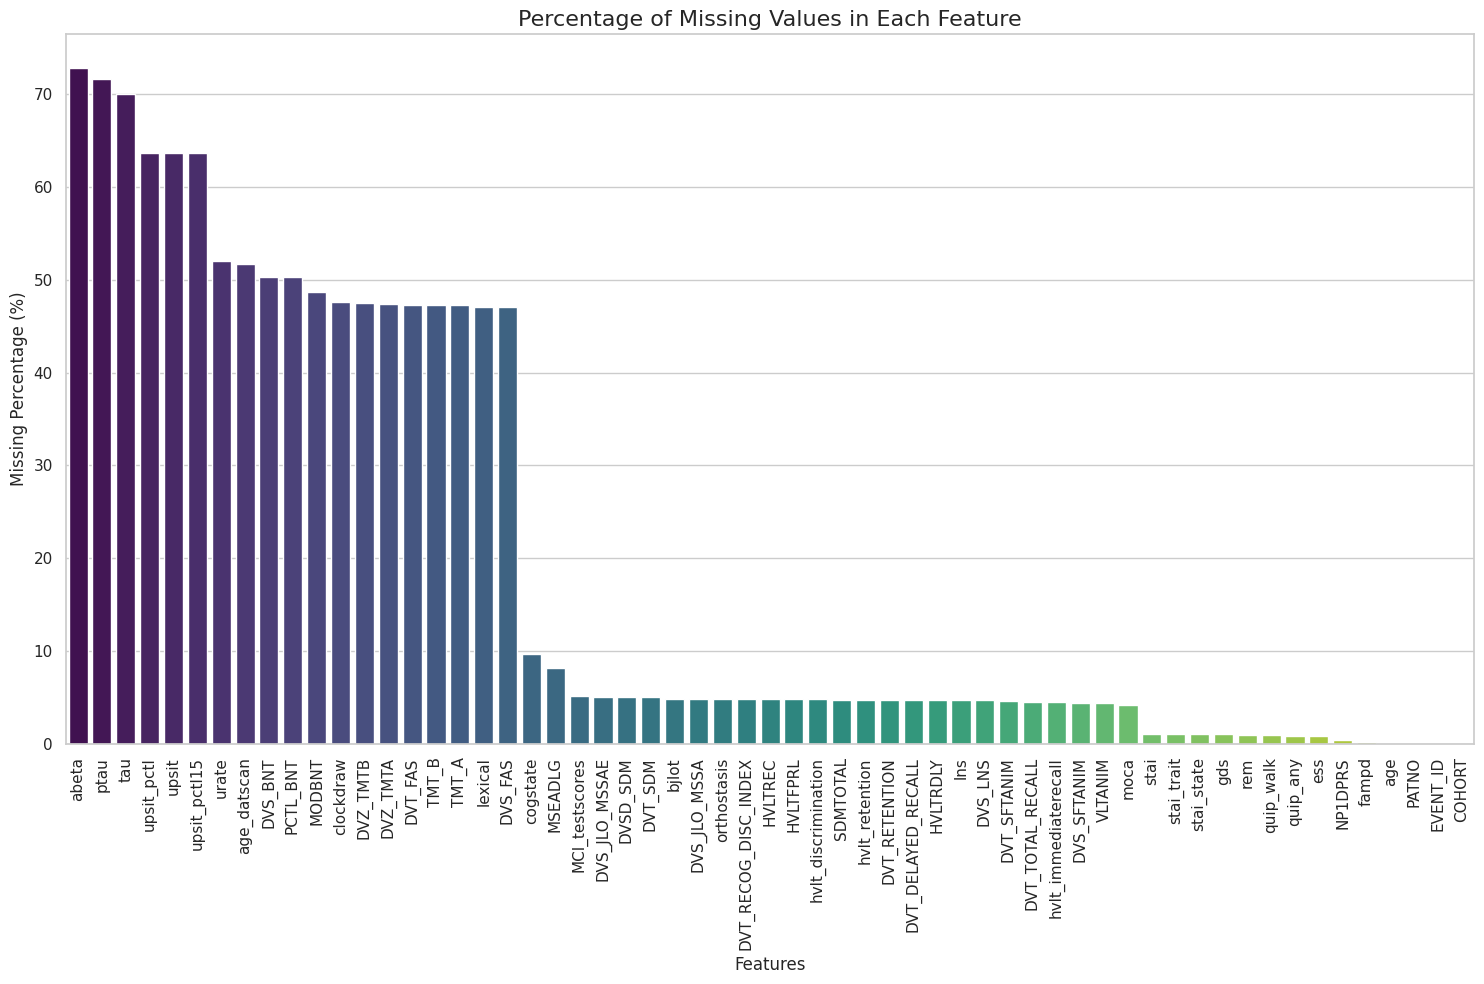

In [6]:
# --- 4. Missing Value Analysis ---
print("--- Missing Value Analysis ---")

# Calculate the number and percentage of missing values for each feature
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Create a new DataFrame with missing value information, sorted by percentage descending
missing_info = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
}).sort_values(by='Missing Percentage', ascending=False)

# Filter out features with no missing values
missing_info = missing_info[missing_info['Missing Count'] >= 0]

print(f"Missing Value Status\n")
display(missing_info)

# Visualize the percentage of missing values
plt.figure(figsize=(15, 10))
sns.barplot(x=missing_info.index, y=missing_info['Missing Percentage'], hue=missing_info.index, palette='viridis', legend=False)
plt.title('Percentage of Missing Values in Each Feature', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Missing Percentage (%)', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



--- Target Variable COHORT Distribution Analysis ---
COHORT Category Distribution:
  - Category 1: 7021 records (45.84%)
  - Category 4: 6136 records (40.06%)
  - Category 2: 1960 records (12.80%)
  - Category 3: 199 records (1.30%)


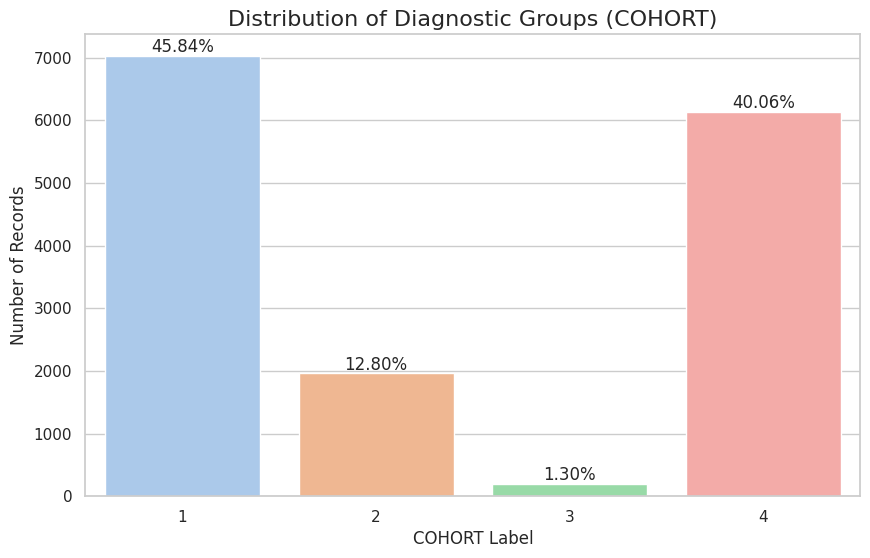

In [7]:
# --- 6. Target Variable (COHORT) Distribution Analysis ---
print("--- Target Variable COHORT Distribution Analysis ---")

# Calculate the count and percentage of each category
cohort_counts = df['COHORT'].value_counts()
cohort_percentages = df['COHORT'].value_counts(normalize=True) * 100

# Print the results
print("COHORT Category Distribution:")
for cohort_id, count in cohort_counts.items():
    print(f"  - Category {cohort_id}: {count} records ({cohort_percentages[cohort_id]:.2f}%)")

# Visualize the category distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='COHORT', data=df, hue='COHORT', palette='pastel', legend=False)
plt.title('Distribution of Diagnostic Groups (COHORT)', fontsize=16)
plt.xlabel('COHORT Label', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)

# Display percentage on each bar
for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(df):.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()



--- Object Type Feature Analysis ---

--- Analyzing EVENT_ID ---
EVENT_ID has 17 unique values.
Top 10 most common EVENT_ID values:
EVENT_ID
BL     4035
V04    2894
V06    1816
V08    1270
V10    1056
V12     993
V13     722
V14     700
V15     489
V17     350
Name: count, dtype: int64


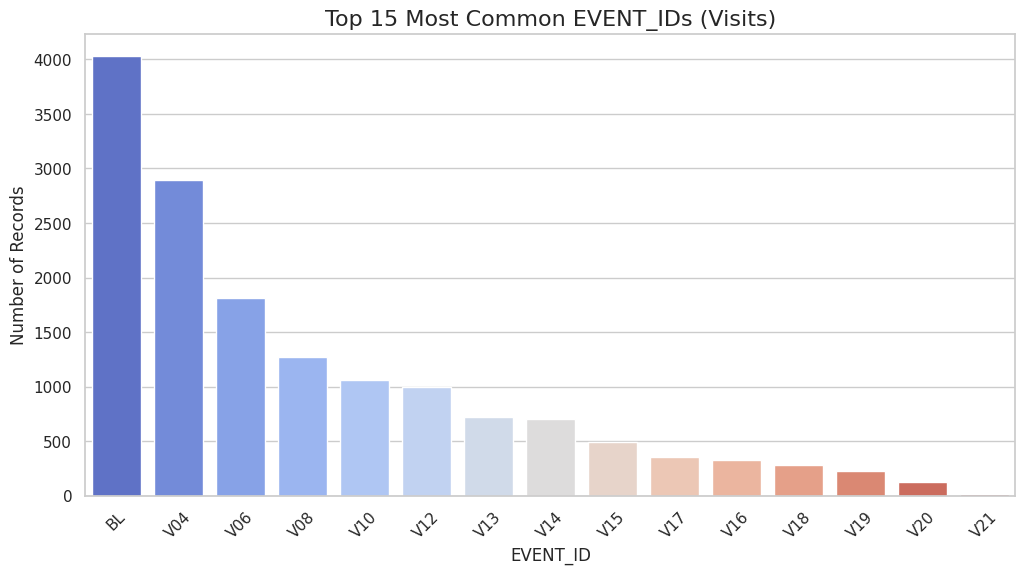

In [8]:
# --- 6. Object Type Feature Analysis ---
print("--- Object Type Feature Analysis ---")

# Analyze EVENT_ID
print("\n--- Analyzing EVENT_ID ---")
event_id_counts = df['EVENT_ID'].value_counts()
print(f"EVENT_ID has {len(event_id_counts)} unique values.")
print("Top 10 most common EVENT_ID values:")
print(event_id_counts.head(10))

# Visualize EVENT_ID distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=event_id_counts.head(15).index, y=event_id_counts.head(15).values, hue=event_id_counts.head(15).index, palette='coolwarm', legend=False)
plt.title('Top 15 Most Common EVENT_IDs (Visits)', fontsize=16)
plt.xlabel('EVENT_ID', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.xticks(rotation=45)
plt.show()




In [9]:
# --- 6.1. View All Unique Values of PCTL_BNT ---
print("--- All Unique Values in 'PCTL_BNT' Column ---")

# Use .dropna().unique() to get all non-null unique values
pctl_bnt_all_unique_values = df['PCTL_BNT'].dropna().unique()

# Print the results
print(f"Found {len(pctl_bnt_all_unique_values)} unique non-null values:")
for value in pctl_bnt_all_unique_values:
    print(f"- {value}")

--- All Unique Values in 'PCTL_BNT' Column ---
Found 15 unique non-null values:
- 41 to 59
- 29 to 40
- 72 to 81
- 19 to 28
- 82 to 89
- 90 to 94
- 60 to 71
- 99
- 3 to 5
- 11 to 18
- 95 to 97
- 6 to 10
- 2
- 1
- <1


In [10]:
# --- 6.2. Load and Verify PCTL_BNT Cleaned Data ---
# Note: We assume the clean_pctl_bnt.py script has been run, generating 'raw_data_2.0.csv'
data_path_v2 = '../data/raw_data_2.0.csv'

print(f"--- Loading v2.0 (PCTL_BNT cleaned) data ---")
print(f"File path: '{data_path_v2}'")
# Load into a new DataFrame for comparison
df_v2 = pd.read_csv(data_path_v2)
print("\nv2.0 data loaded successfully!")

pctl_bnt_all_unique_values = df_v2['PCTL_BNT'].dropna().unique()
# Additional verification of the PCTL_BNT column
print(f"Found {len(pctl_bnt_all_unique_values)} unique non-null values:")
for value in pctl_bnt_all_unique_values:
    print(f"- {value}")



--- Loading v2.0 (PCTL_BNT cleaned) data ---
File path: '../data/raw_data_2.0.csv'

v2.0 data loaded successfully!
Found 15 unique non-null values:
- 50.0
- 34.5
- 76.5
- 23.5
- 85.5
- 92.0
- 65.5
- 99.0
- 4.0
- 14.5
- 96.0
- 8.0
- 2.0
- 1.0
- 0.0


In [11]:
# --- 5. Outlier Analysis (IQR Method) ---
print("--- Outlier Detection using IQR Method ---")

# === 1. Load the list of numerical features from analysis_features.json ===
with open('../data/analysis_features.json', 'r', encoding='utf-8') as f:
    analysis_features = json.load(f)

numeric_features_for_outliers = analysis_features.get('numerical_features', [])

# === 2. Ensure these features exist in df_v2 ===
numeric_features_for_outliers = [
    f for f in numeric_features_for_outliers if f in df_v2.columns
]

# === 3. Remove ID and target columns (to prevent interference) ===
numeric_features_for_outliers = [
    col for col in numeric_features_for_outliers
    if col not in ['PATNO', 'COHORT']
]

# === 4. Create a results list ===
outlier_summary = []

# === 5. Iterate through all numerical features and apply the IQR method ===
for col in numeric_features_for_outliers:
    feature_data = df_v2[col].dropna()  # Remove missing values
    
    # If the feature has no data, skip it
    if feature_data.empty:
        continue
    
    # Calculate Q1, Q3, IQR
    Q1 = feature_data.quantile(0.25)
    Q3 = feature_data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier boundaries (using 1.5 * IQR is common)
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # Find outliers
    outliers = feature_data[(feature_data < lower_bound) | (feature_data > upper_bound)]
    outlier_count = len(outliers)
    total_count = len(feature_data)
    outlier_ratio = outlier_count / total_count if total_count > 0 else np.nan
    
    # Store the results
    outlier_summary.append({
        'Feature': col,
        'Q1': round(Q1, 2),
        'Q3': round(Q3, 2),
        'IQR': round(IQR, 2),
        'Lower Bound': round(lower_bound, 2),
        'Upper Bound': round(upper_bound, 2),
        'Outlier Count': outlier_count,
        'Total Count': total_count,
        'Outlier Ratio (%)': round(outlier_ratio * 100, 2)
    })

# === 6. Convert to DataFrame and display ===
outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df.sort_values(by='Outlier Ratio (%)', ascending=False)
outlier_df


--- Outlier Detection using IQR Method ---


,Feature,Q1,Q3,IQR,Lower Bound,Upper Bound,Outlier Count,Total Count,Outlier Ratio (%)
24,TMT_B,57.00,105.00,48.00,-87.00,249.00,423,8075,5.24
19,MODBNT,56.00,60.00,4.00,44.00,72.00,262,7862,3.33
30,clockdraw,6.00,7.00,1.00,3.00,10.00,239,8032,2.98
18,HVLTREC,11.00,12.00,1.00,8.00,15.00,371,14577,2.55
23,TMT_A,26.00,44.00,18.00,-28.00,98.00,200,8084,2.47
20,MSEADLG,90.00,100.00,10.00,60.00,130.00,243,14060,1.73
39,ptau,11.36,18.21,6.86,-9.21,38.78,48,4355,1.10
32,gds,0.00,3.00,3.00,-9.00,12.00,152,15158,1.00
16,HVLTFPRL,0.00,1.00,1.00,-3.00,4.00,143,14577,0.98
44,tau,131.60,209.78,78.18,-102.93,444.30,35,4594,0.76


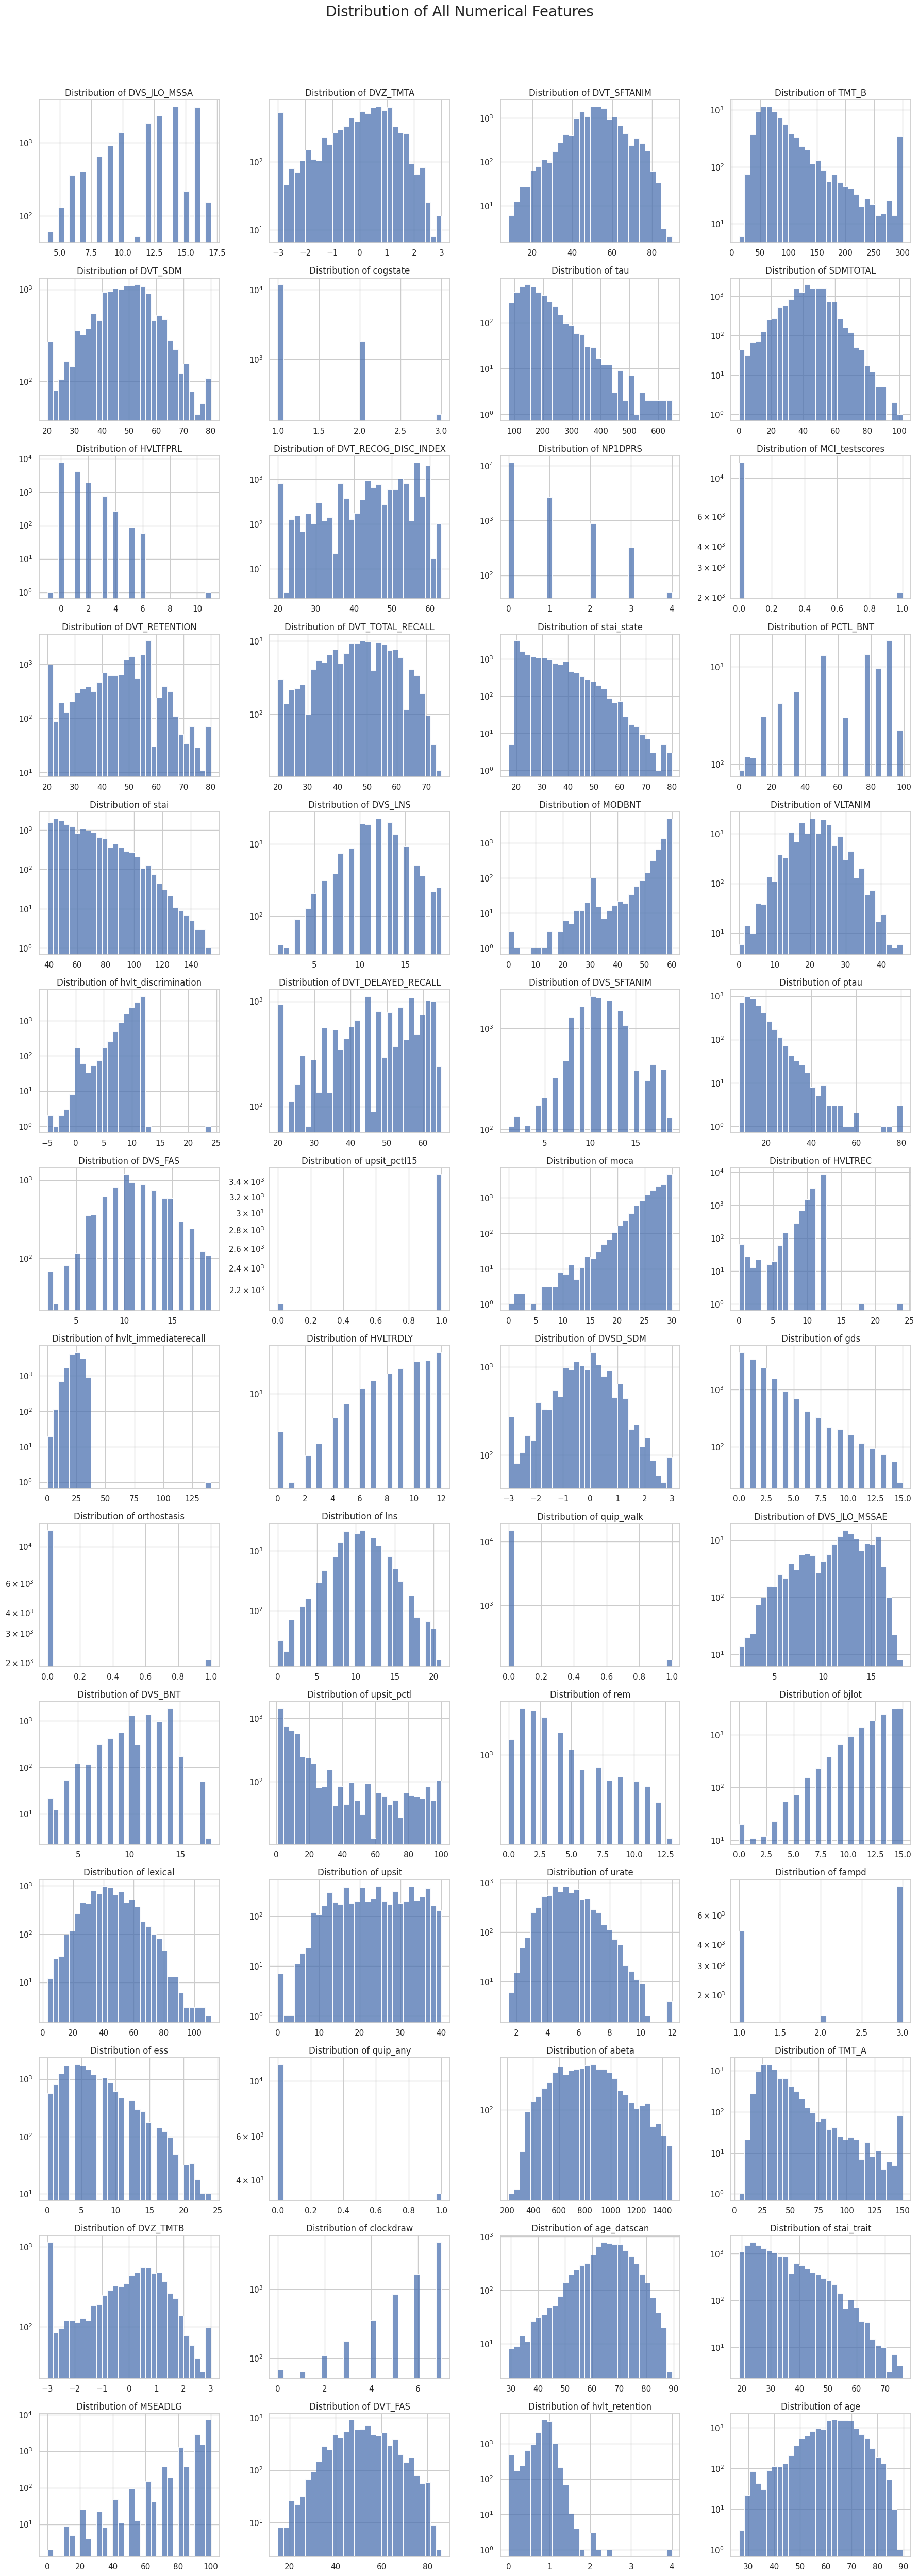

In [12]:
numeric_features = (
    df_v2.select_dtypes(include=np.number)
      .drop(columns=['PATNO', 'COHORT'])
      .columns
)

n_features = len(numeric_features)
n_cols = 4
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 3.5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.histplot(df_v2[feature].dropna(), kde=False, ax=axes[i], bins=30)
    axes[i].set_yscale('log')
    axes[i].set_title(f'Distribution of {feature}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Distribution of All Numerical Features', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


--- Plotting Boxplots for All Numerical Features (Grouped by COHORT) ---
Detected 56 numerical features.


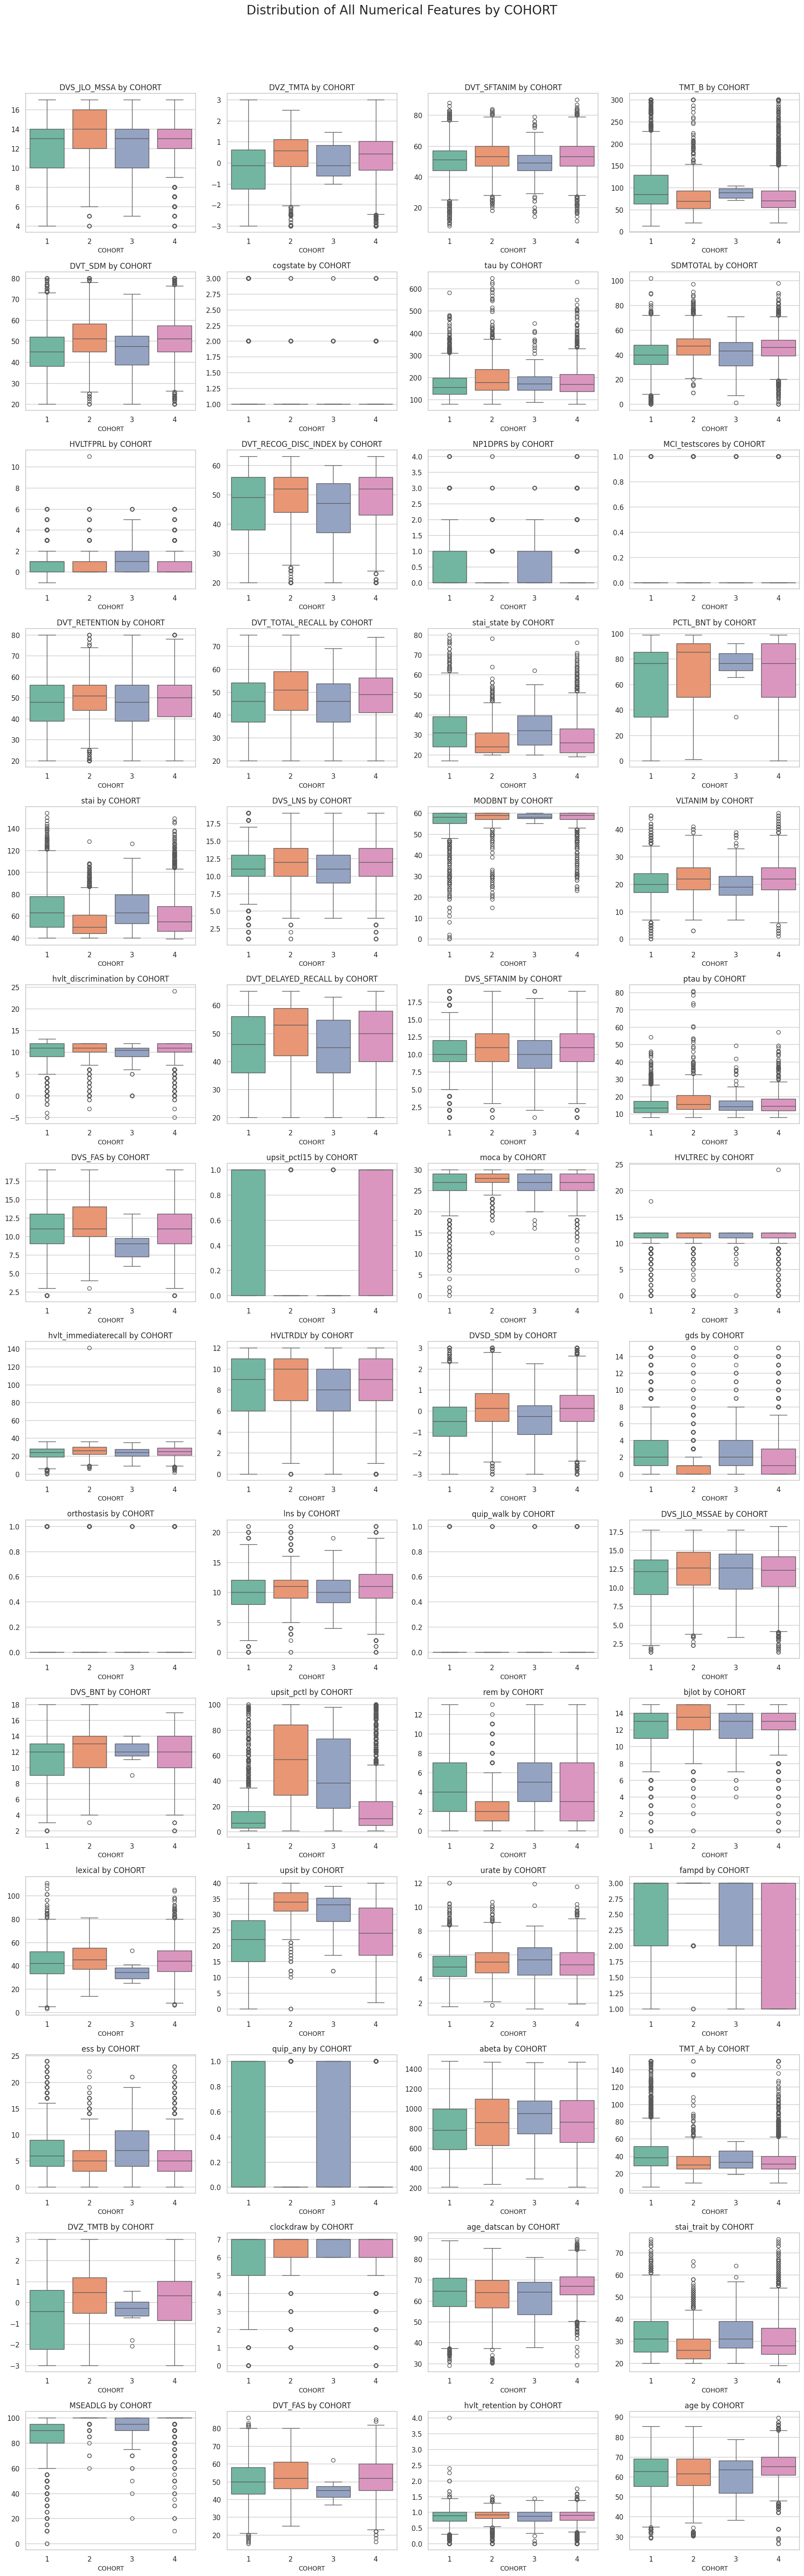

In [13]:
# --- Plotting Boxplots for All Numerical Features by COHORT ---
print("--- Plotting Boxplots for All Numerical Features (Grouped by COHORT) ---")

# 1️⃣ Select numerical features (consistent with previous steps)
numeric_features = (
    df_v2.select_dtypes(include=np.number)
      .drop(columns=['PATNO', 'COHORT'])
      .columns
)

n_features = len(numeric_features)
print(f"Detected {n_features} numerical features.")

# 2️⃣ Layout parameters
n_cols = 4
n_rows = math.ceil(n_features / n_cols)

# 3️⃣ Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# 4️⃣ Iterate through each feature and plot a boxplot
for i, feature in enumerate(numeric_features):
    sns.boxplot(
        x='COHORT', 
        y=feature, 
        data=df_v2, 
        ax=axes[i],
        hue='COHORT', 
        palette='Set2',
        legend=False
    )
    axes[i].set_title(f'{feature} by COHORT', fontsize=12)
    axes[i].set_xlabel('COHORT', fontsize=10)
    axes[i].set_ylabel('')

# Remove any extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 5️⃣ Main title and layout adjustment
fig.suptitle('Distribution of All Numerical Features by COHORT', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


--- Feature Correlation Analysis ---
Calculating correlation matrix for the following 15 random features:
['DVT_SFTANIM' 'DVS_SFTANIM' 'MSEADLG' 'age' 'hvlt_discrimination' 'upsit'
 'rem' 'DVS_BNT' 'DVT_TOTAL_RECALL' 'MODBNT' 'cogstate' 'VLTANIM'
 'orthostasis' 'urate' 'DVS_JLO_MSSA']


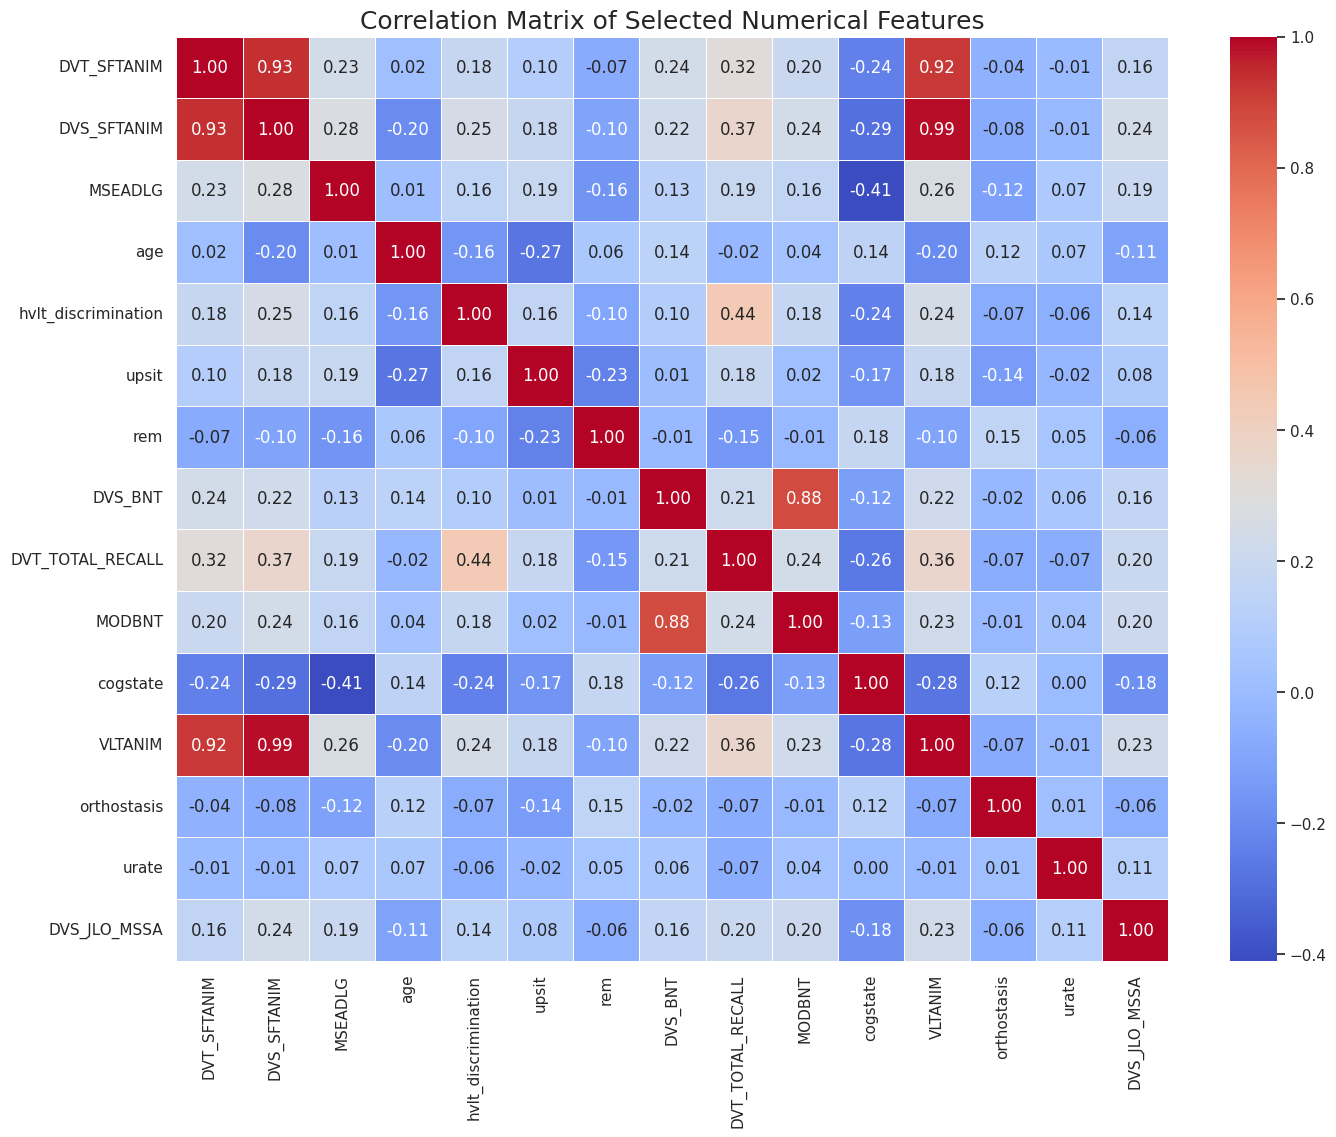

In [14]:
# --- 9. Feature Correlation Heatmap ---
print("--- Feature Correlation Analysis ---")

# Calculate the correlation matrix for numerical features
# We will randomly select a subset (e.g., 15) of the numeric_features for visualization,
# because a heatmap with over 50 features would be too dense to read.
if len(numeric_features) > 15:
    corr_features = np.random.choice(numeric_features, 15, replace=False)
else:
    corr_features = numeric_features

print(f"Calculating correlation matrix for the following {len(corr_features)} random features:")
print(corr_features)

correlation_matrix = df_v2[corr_features].corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Selected Numerical Features', fontsize=18)
plt.show()

